In [45]:
import cdsapi
import xarray as xr
import numpy as np
import pandas as pd
from urllib.request import urlopen, urlretrieve
import os
import zipfile
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# create correlation plots
import seaborn as sns
import pickle

ERA5 Land Reanalysis Data Preparation

In [10]:
# Start the CDS API client
cds = cdsapi.Client()

# Dataset and download flag
dataset = "reanalysis-era5-land"
download_flag = False

# API parameters
params = {
        'variable': [
            'total_precipitation'
        ],
        'format': 'netcdf.zip',
        'area': [
            52.2, -2.1, 51.5,
            -1,
        ],
        'year': '2022',
        # changing it to 2 and then 3
        'month': [
            '1', '2', '3'
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
}

# Retrieve the file
fl = cds.retrieve(dataset, params)

# The location is the URL where the data can be downloaded
url = fl.location
zip_file_name = "temp.zip"
urlretrieve(url, zip_file_name)  # download the zip file to a local file

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(".")  # extract all files to the current directory

# Find the .nc file in the current directory
nc_file_name = next(f for f in os.listdir(".") if f.endswith(".nc"))

# Now you can open the .nc file with xarray
ds = xr.open_dataset(nc_file_name)

# Don't forget to clean up the temporary files when you're done with them
os.remove(zip_file_name)

2023-09-01 11:08:00,419 INFO Welcome to the CDS
2023-09-01 11:08:00,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-09-01 11:08:00,530 INFO Request is queued
2023-09-01 11:08:01,595 INFO Request is running
2023-09-01 11:14:19,131 INFO Request is completed


In [11]:
# print out the downloaded dataset information
ds

<xarray.Dataset>
Dimensions:    (longitude: 12, latitude: 8, time: 2160)
Coordinates:
  * longitude  (longitude) float32 -2.1 -2.0 -1.9 -1.8 ... -1.3 -1.2 -1.1 -1.0
  * latitude   (latitude) float32 52.2 52.1 52.0 51.9 51.8 51.7 51.6 51.5
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-03-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-01 10:13:39 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [12]:
df = ds.to_dataframe().reset_index()[['longitude', 'latitude', 'time', 'tp']]

# get unique combinations of longitude and latitude
unique_coords = df[['latitude', 'longitude']].drop_duplicates().values

# tolerance for floating point comparison
tolerance = 1e-5 

# dictionary to store dataframes for each coordinate
dataframes = {}

for coord in unique_coords:
    longitude, latitude = coord
    df_temp = df[np.isclose(df['latitude'], longitude, rtol=tolerance) & np.isclose(df['longitude'], latitude, rtol=tolerance)]
    # use a tuple of coordinates as the key
    dataframes[(longitude, latitude)] = df_temp

In [13]:
print("Keys in the dictionary:", dataframes.keys())
print("Number of unique coordinate pairs:", len(dataframes))

Keys in the dictionary: dict_keys([(52.2, -2.1), (52.1, -2.1), (52.0, -2.1), (51.9, -2.1), (51.8, -2.1), (51.7, -2.1), (51.6, -2.1), (51.5, -2.1), (52.2, -2.0), (52.1, -2.0), (52.0, -2.0), (51.9, -2.0), (51.8, -2.0), (51.7, -2.0), (51.6, -2.0), (51.5, -2.0), (52.2, -1.9), (52.1, -1.9), (52.0, -1.9), (51.9, -1.9), (51.8, -1.9), (51.7, -1.9), (51.6, -1.9), (51.5, -1.9), (52.2, -1.8), (52.1, -1.8), (52.0, -1.8), (51.9, -1.8), (51.8, -1.8), (51.7, -1.8), (51.6, -1.8), (51.5, -1.8), (52.2, -1.7), (52.1, -1.7), (52.0, -1.7), (51.9, -1.7), (51.8, -1.7), (51.7, -1.7), (51.6, -1.7), (51.5, -1.7), (52.2, -1.6), (52.1, -1.6), (52.0, -1.6), (51.9, -1.6), (51.8, -1.6), (51.7, -1.6), (51.6, -1.6), (51.5, -1.6), (52.2, -1.5), (52.1, -1.5), (52.0, -1.5), (51.9, -1.5), (51.8, -1.5), (51.7, -1.5), (51.6, -1.5), (51.5, -1.5), (52.2, -1.4), (52.1, -1.4), (52.0, -1.4), (51.9, -1.4), (51.8, -1.4), (51.7, -1.4), (51.6, -1.4), (51.5, -1.4), (52.2, -1.3), (52.1, -1.3), (52.0, -1.3), (51.9, -1.3), (51.8, -1.3),

In [8]:
# remove the temporary file
ds.close()
os.remove(nc_file_name)

In [16]:
# Save in local disc for accessibility 
with open('coordinates_dataframes.pkl', 'wb') as f:
    pickle.dump(dataframes, f)

In [17]:
# Importing data from local pickle file
with open('coordinates_dataframes.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [18]:
# Delete all the unwanted coordinates
del loaded_data[(52.20000076293945, -2.0999999046325684)]
del loaded_data[(52.099998474121094, -2.0999999046325684)]
del loaded_data[(52.0, -2.0999999046325684)]
del loaded_data[(51.900001525878906, -2.0999999046325684)]
del loaded_data[(51.5, -2.0999999046325684)]
del loaded_data[(52.20000076293945, -2.0)]
del loaded_data[(52.099998474121094, -2.0)]
del loaded_data[(52.0, -2.0)]
del loaded_data[(51.5, -2.0)]
del loaded_data[(52.20000076293945, -1.899999976158142)]
del loaded_data[(52.099998474121094, -1.899999976158142)]
del loaded_data[(51.5, -1.899999976158142)]
del loaded_data[(52.20000076293945, -1.7999999523162842)]
del loaded_data[(52.099998474121094, -1.7999999523162842)]
del loaded_data[(52.20000076293945, -1.7000000476837158)]
del loaded_data[(52.099998474121094, -1.7000000476837158)]
del loaded_data[(52.20000076293945, -1.600000023841858)]
del loaded_data[(52.099998474121094, -1.600000023841858)]
del loaded_data[(51.5, -1.600000023841858)]
del loaded_data[(52.20000076293945, -1.5)]
del loaded_data[(51.599998474121094, -1.5)]
del loaded_data[(51.5, -1.5)]
del loaded_data[(52.20000076293945, -1.399999976158142)]
del loaded_data[(51.599998474121094, -1.399999976158142)]
del loaded_data[(51.5, -1.399999976158142)]
del loaded_data[(51.599998474121094, -1.2999999523162842)]
del loaded_data[(51.5, -1.2999999523162842)]
del loaded_data[(51.599998474121094, -1.2000000476837158)]
del loaded_data[(51.5, -1.2000000476837158)]
del loaded_data[(52.20000076293945, -1.100000023841858)]
del loaded_data[(52.099998474121094, -1.100000023841858)]
del loaded_data[(52.0, -1.100000023841858)]
del loaded_data[(51.70000076293945, -1.100000023841858)]
del loaded_data[(51.599998474121094, -1.100000023841858)]
del loaded_data[(51.5, -1.100000023841858)]
del loaded_data[(52.20000076293945, -1.0)]
del loaded_data[(52.099998474121094, -1.0)]
del loaded_data[(52.0, -1.0)]
del loaded_data[(51.70000076293945, -1.0)]
del loaded_data[(51.599998474121094, -1.0)]
del loaded_data[(51.5, -1.0)]     

Sub-Catchments Segmentation

In [21]:
# Manually specify which keys belong to each category
keys_category_1 = [(51.79999923706055, -2.0999999046325684), (51.599998474121094, -2.0999999046325684), (51.70000076293945, -2.0999999046325684), (51.900001525878906, -2.0), (51.79999923706055, -2.0), (51.70000076293945, -2.0), (51.599998474121094, -2.0), 
                   (51.900001525878906, -1.899999976158142), (51.79999923706055, -1.899999976158142), (51.70000076293945, -1.899999976158142), (51.599998474121094, -1.899999976158142), 
                   (51.79999923706055, -1.7999999523162842), (51.70000076293945, -1.7999999523162842), (51.599998474121094, -1.7999999523162842), (51.5, -1.7999999523162842), 
                   (51.70000076293945, -1.7000000476837158), (51.599998474121094, -1.7000000476837158), (51.5, -1.7000000476837158), (51.599998474121094, -1.600000023841858)]
keys_category_2 = [(52.0, -1.899999976158142), (51.900001525878906, -1.899999976158142), (52.0, -1.7999999523162842), (51.900001525878906, -1.7999999523162842), (51.79999923706055, -1.7999999523162842), 
                   (52.0, -1.7000000476837158), (51.900001525878906, -1.7000000476837158), (51.79999923706055, -1.7000000476837158), (51.70000076293945, -1.7000000476837158), (52.0, -1.600000023841858), 
                   (51.900001525878906, -1.600000023841858), (51.79999923706055, -1.600000023841858), (51.70000076293945, -1.600000023841858), (52.0, -1.5), (51.900001525878906, -1.5), 
                   (51.79999923706055, -1.5), (51.70000076293945, -1.5), (51.900001525878906, -1.399999976158142), (51.79999923706055, -1.399999976158142), 
                   (51.70000076293945, -1.399999976158142), (51.900001525878906, -1.2999999523162842)]  
keys_category_3 = [(52.0, -1.5), (52.099998474121094, -1.399999976158142), (52.0, -1.399999976158142), (52.20000076293945, -1.2999999523162842), (52.099998474121094, -1.2999999523162842), 
                   (52.0, -1.2999999523162842), (51.900001525878906, -1.2999999523162842), (51.79999923706055, -1.2999999523162842), (51.70000076293945, -1.2999999523162842), 
                   (52.20000076293945, -1.2000000476837158), (52.099998474121094, -1.2000000476837158), (52.0, -1.2000000476837158), (51.900001525878906, -1.2000000476837158), 
                   (51.79999923706055, -1.2000000476837158), (51.70000076293945, -1.2000000476837158), (51.900001525878906, -1.100000023841858), (51.900001525878906, -1.0), 
                   (51.79999923706055, -1.100000023841858), (51.79999923706055, -1.0)]

# Initialize an empty dictionary to hold the categories
categorized_keys = {}

# Add keys to the dictionary under their respective categories
categorized_keys['thames upper'] = keys_category_1
categorized_keys['cotsworlds'] = keys_category_2
categorized_keys['cherwell and ray'] = keys_category_3

In [22]:
tu_df = pd.DataFrame()
for i in categorized_keys['thames upper']:
    df1 = loaded_data[i]
    if i == (51.70000076293945, -2.0999999046325684):
        df1['tp'] = df1['tp']*0.5
    elif i == (51.900001525878906, -2.0):
        df1['tp'] = df1['tp']*0.4
    elif i == (51.599998474121094, -2.0):
        df1['tp'] = df1['tp']*0.6
    elif i == (51.900001525878906, -1.899999976158142):
        df1['tp'] = df1['tp']*0.25
    elif i == (51.79999923706055, -1.899999976158142):
        df1['tp'] = df1['tp']*0.8
    elif i == (51.599998474121094, -1.899999976158142):
        df1['tp'] = df1['tp']*0.8
    elif i == (51.79999923706055, -1.7999999523162842):
        df1['tp'] = df1['tp']*0.2
    elif i == (51.70000076293945, -1.7000000476837158):
        df1['tp'] = df1['tp']*0.6
    elif i == (51.599998474121094, -2.0999999046325684):
        df1['tp'] = df1['tp']*0.2
    elif i == (51.79999923706055, -2.0999999046325684):
        df1['tp'] = df1['tp']*0.2
    elif i == (51.5, -1.7999999523162842):
        df1['tp'] = df1['tp']*0.4
    elif i == (51.5, -1.7000000476837158):
        df1['tp'] = df1['tp']*0.3
    elif i == (51.599998474121094, -1.600000023841858):
        df1['tp'] = df1['tp']*0.4
    tu_df = pd.concat([tu_df, df1], ignore_index=True)

In [23]:
cw_df = pd.DataFrame()
for i in categorized_keys['cotsworlds']:
    df1 = loaded_data[i]
    if i == (51.900001525878906, -1.899999976158142):
        df1['tp'] = df1['tp']*0.6
    elif i == (52.0, -1.7999999523162842):
        df1['tp'] = df1['tp']*0.5
    elif i == (51.79999923706055, -1.7999999523162842):
        df1['tp'] = df1['tp']*0.8
    elif i == (52.0, -1.7000000476837158):
        df1['tp'] = df1['tp']*0.5
    elif i == (51.70000076293945, -1.7000000476837158):
        df1['tp'] = df1['tp']*0.4
    elif i == (51.70000076293945, -1.600000023841858):
        df1['tp'] = df1['tp']*0.9
    elif i == (52.0, -1.5):
        df1['tp'] = df1['tp']*0.2
    elif i == (51.70000076293945, -1.5):
        df1['tp'] = df1['tp']*0.75
    elif i == (51.70000076293945, -1.399999976158142):
        df1['tp'] = df1['tp']*0.5
    elif i == (51.900001525878906, -1.2999999523162842):
        df1['tp'] = df1['tp']*0.2
    elif i == (52.0, -1.899999976158142):
        df1['tp'] = df1['tp']*0.2
    elif i == (52.0, -1.600000023841858):
        df1['tp'] = df1['tp']*0.25
    cw_df = pd.concat([cw_df, df1], ignore_index=True)

In [24]:
cr_df = pd.DataFrame()
for i in categorized_keys['cherwell and ray']:
    df1 = loaded_data[i]
    if i == (51.900001525878906, -1.2999999523162842):
        df1['tp'] = df1['tp']*0.2
    elif i == (52.0, -1.5):
        df1['tp'] = df1['tp']*0.4
    elif i == (2.099998474121094, -1.399999976158142):
        df1['tp'] = df1['tp']*0.95
    elif i == (52.20000076293945, -1.2999999523162842):
        df1['tp'] = df1['tp']*0.5 
    elif i == (51.70000076293945, -1.2999999523162842):
        df1['tp'] = df1['tp']*0.4
    elif i == (52.20000076293945, -1.2000000476837158):
        df1['tp'] = df1['tp']*0.5
    elif i == (52.099998474121094, -1.2000000476837158):
        df1['tp'] = df1['tp']*0.5
    elif i == (52.0, -1.2000000476837158):
        df1['tp'] = df1['tp']*0.4
    elif i == (51.79999923706055, -1.2000000476837158):
        df1['tp'] = df1['tp']*0.9
    elif i == (51.70000076293945, -1.2000000476837158):
        df1['tp'] = df1['tp']*0.35
    elif i == (51.900001525878906, -1.100000023841858):
        df1['tp'] = df1['tp']*0.8
    elif i == (51.79999923706055, -1.100000023841858):
        df1['tp'] = df1['tp']*0.25
    elif i == (51.900001525878906, -1.0):
        df1['tp'] = df1['tp']*0.6
    elif i == (51.79999923706055, -1.0):
        df1['tp'] = df1['tp']*0.2
    elif i == (52.099998474121094, -1.5):
        df1['tp'] = df1['tp']*0.2
    cr_df = pd.concat([cr_df, df1], ignore_index=True)

In [26]:
def processing(df):
    df = df.groupby('time').sum().reset_index()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df.drop(['longitude', 'latitude'], axis=1, inplace=True)
    return df

pro_cr_df = processing(cr_df)
pro_cw_df = processing(cw_df)
pro_tu_df = processing(tu_df)

3.1.1.	Sandford Hydro Generation Data

In [47]:
# loading the generation data file
df_gen = pd.read_csv('SHL_003.csv')

# setting Timestamp columns as the index
df_gen['Timestamp'] = pd.to_datetime(df_gen['Timestamp'])
df_gen = df_gen.set_index('Timestamp')

# Extract the generation column and set it to a dataframe
df_gen = df_gen['Sandford Hydro (KW)']
df_gen = pd.DataFrame(df_gen)

In [48]:
# Aggregating the generation dataset into daily and hourly interval for testing
df_gen_hourly = df_gen.resample('h').mean()
df_gen_daily = df_gen.resample('d').mean()

# Interpolating the missing values
df_gen_hourly = df_gen_hourly.interpolate(method='linear', limit_direction='both', axis=0)
df_gen_daily = df_gen_daily.interpolate(method='linear', limit_direction='both', axis=0)

# renaming the column
df_gen_hourly.rename(columns={'Sandford Hydro (KW)': 'KW'}, inplace=True)
df_gen_daily.rename(columns={'Sandford Hydro (KW)': 'KW'}, inplace=True)

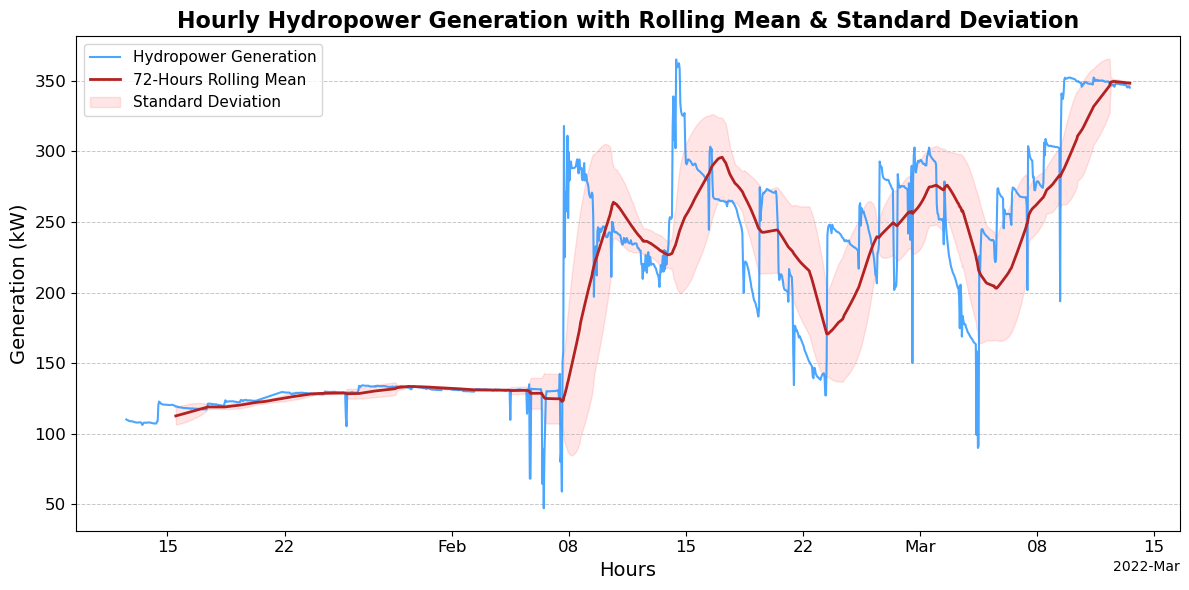

Hourly Average Coefficient of Variation:9.547727817655753 


In [49]:
window_size = 72

# Calculate rolling mean and standard deviation
rolling_mean = df_gen_hourly['KW'].rolling(window=window_size).mean()
rolling_std = df_gen_hourly['KW'].rolling(window=window_size).std()

# Improved aesthetics
plt.figure(figsize=(12, 6))
plt.plot(df_gen_hourly['KW'], label='Hydropower Generation', color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.plot(rolling_mean, color='firebrick', label='72-Hours Rolling Mean', linewidth=2)
plt.fill_between(df_gen_hourly.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.1, label='Standard Deviation')

# Grid, title, and labels
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.title('Hourly Hydropower Generation with Rolling Mean & Standard Deviation', fontsize=16, fontweight='bold')
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Generation (kW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve x-axis date formatting for better clarity
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Legend
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

cov = ((rolling_std/rolling_mean)*100).mean()

print('Hourly Average Coefficient of Variation:{} '.format(cov))

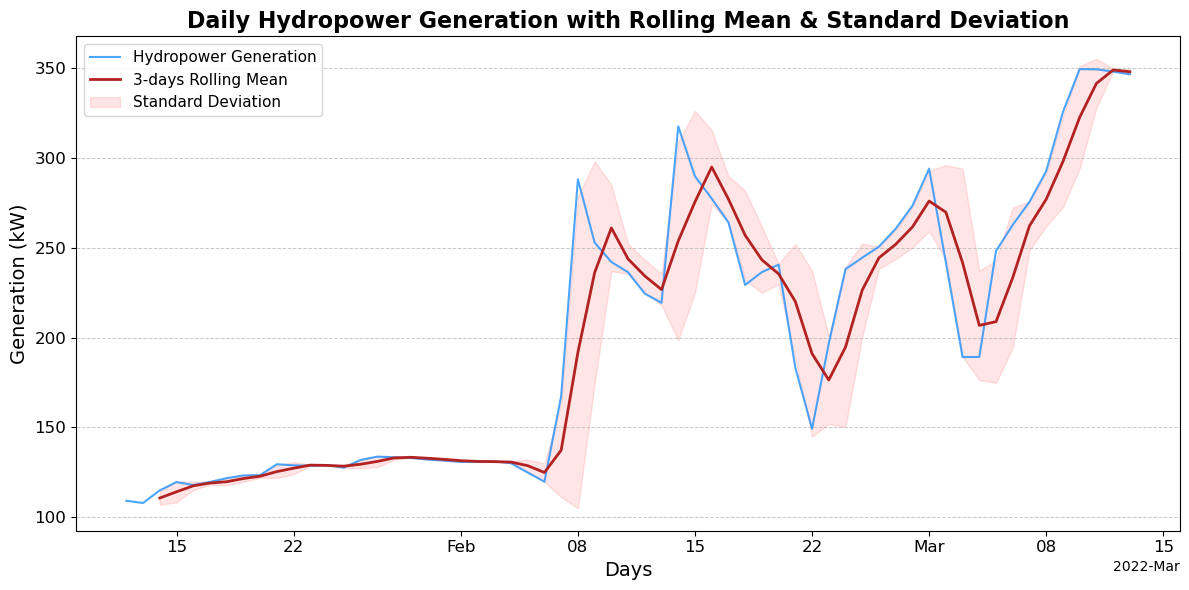

Daily Average Coefficient of Variation:7.346110765641395 


In [50]:
window_size = 3

# Calculate rolling mean and standard deviation
rolling_mean = df_gen_daily['KW'].rolling(window=window_size).mean()
rolling_std = df_gen_daily['KW'].rolling(window=window_size).std()

# Improved aesthetics
plt.figure(figsize=(12, 6))
plt.plot(df_gen_daily['KW'], label='Hydropower Generation', color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.plot(rolling_mean, color='firebrick', label='3-days Rolling Mean', linewidth=2)
plt.fill_between(df_gen_daily.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.1, label='Standard Deviation')

# Grid, title, and labels
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.title('Daily Hydropower Generation with Rolling Mean & Standard Deviation', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Generation (kW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve x-axis date formatting for better clarity
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Legend
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

cov = ((rolling_std/rolling_mean)*100).mean()

print('Daily Average Coefficient of Variation:{} '.format(cov))

3.1.3.	ERA5 Land Precipitation Data 

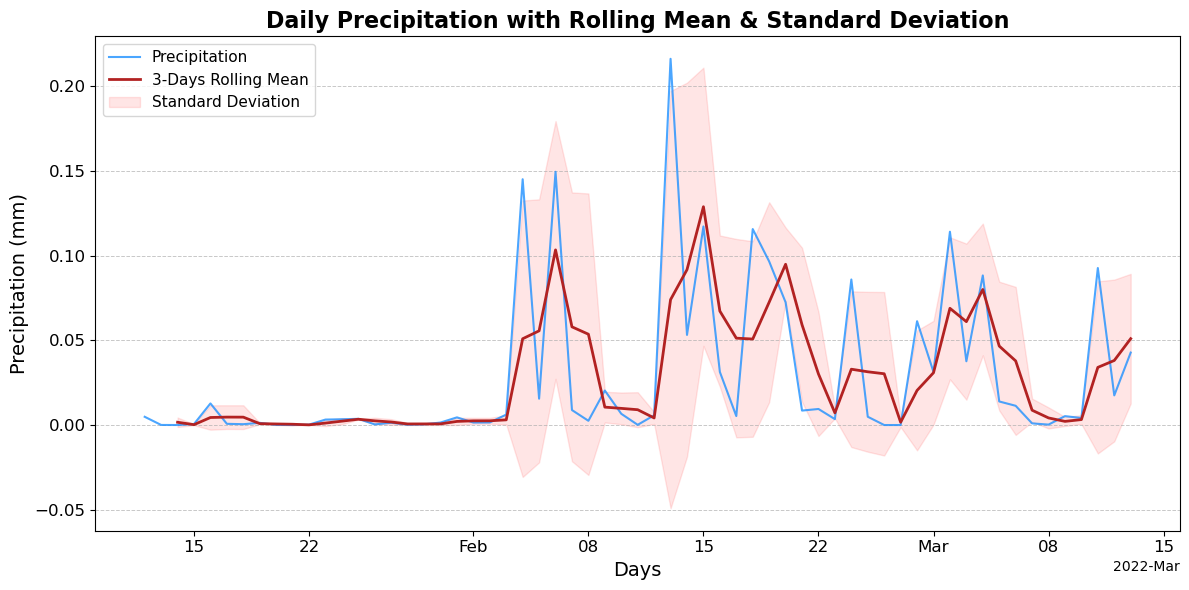

Daily Average Coefficient of Variation:106.6095886426589 


In [55]:
# Sum up all the sub-catchments precipitation data into one for visualisation purpose
values_sum = pro_cr_df.values + pro_cw_df.values + pro_tu_df.values

# Create new DataFrame with specified column names and index
df_ERA5L = pd.DataFrame(values_sum, columns=pro_cr_df.columns, index=pro_cr_df.index)

# rename the column
df_ERA5L.rename(columns={'cr': 'tp'}, inplace=True)

# resampling the dataset into daily aggregation
df_ERA5L = df_ERA5L.resample('d').mean()

# pull data after 12-1-2022
df_temp = df_ERA5L[(df_ERA5L.index > '2022-01-11') & (df_ERA5L.index < '2022-03-14')]

# Calculate rolling mean and standard deviation
rolling_mean = df_temp['tp'].rolling(window=window_size).mean()
rolling_std = df_temp['tp'].rolling(window=window_size).std()

# Improved aesthetics
plt.figure(figsize=(12, 6))
plt.plot(df_temp['tp'], label='Precipitation', color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.plot(rolling_mean, color='firebrick', label='3-Days Rolling Mean', linewidth=2)
plt.fill_between(df_temp.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.1, label='Standard Deviation')

# Grid, title, and labels
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.title('Daily Precipitation with Rolling Mean & Standard Deviation', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve x-axis date formatting for better clarity
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Legend
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

cov = ((rolling_std/rolling_mean)*100).mean()

print('Daily Average Coefficient of Variation:{} '.format(cov))

3.2.1.	Catchment Area Segmentation – Spatial Distribution

In [56]:
daily_cr = pro_cr_df.resample('d').mean()
daily_cw = pro_cw_df.resample('d').mean()
daily_tu = pro_tu_df.resample('d').mean()

In [57]:
scaler = MinMaxScaler()
norm_daily_cr = scaler.fit_transform(daily_cr)
norm_daily_cw = scaler.fit_transform(daily_cw)
norm_daily_tu = scaler.fit_transform(daily_tu)
norm_daily_sf = scaler.fit_transform(daily_gen)

In [58]:
norm_daily_sf = pd.DataFrame(norm_daily_sf, columns=daily_gen.columns, index=daily_gen.index)
norm_daily_cr = pd.DataFrame(norm_daily_cr, columns=daily_cr.columns, index=daily_cr.index)
norm_daily_cw = pd.DataFrame(norm_daily_cw, columns=daily_cw.columns, index=daily_cw.index)
norm_daily_tu = pd.DataFrame(norm_daily_tu, columns=daily_tu.columns, index=daily_tu.index)

In [59]:
norm_daily_cr = norm_daily_cr.loc['2022-01-12': '2022-03-13']
norm_daily_cw = norm_daily_cw.loc['2022-01-12': '2022-03-13']
norm_daily_tu = norm_daily_tu.loc['2022-01-12': '2022-03-13']

In [60]:
merged_daily_df = pd.concat([norm_daily_cr, norm_daily_cw, norm_daily_tu, norm_daily_sf], axis=1)
# rename the column
merged_daily_df.columns = ['cr', 'cw', 'tu', 'sf']

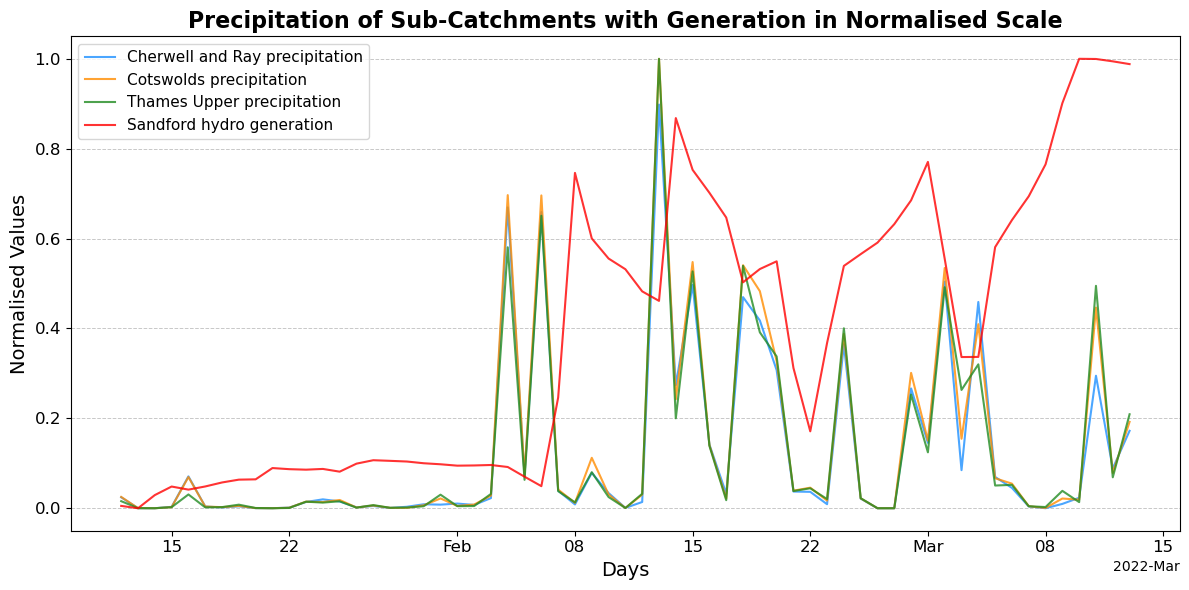

In [61]:
import matplotlib.dates as mdates
# Improved aesthetics
plt.figure(figsize=(12, 6))
plt.plot(merged_daily_df['cr'], label='Cherwell and Ray precipitation', color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.plot(merged_daily_df['cw'], label='Cotswolds precipitation', color='darkorange', linewidth=1.5, alpha=0.8)
plt.plot(merged_daily_df['tu'], label='Thames Upper precipitation', color='forestgreen', linewidth=1.5, alpha=0.8)
plt.plot(merged_daily_df['sf'], label='Sandford hydro generation', color='red', linewidth=1.5, alpha=0.8)

# Grid, title, and labels
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.title('Precipitation of Sub-Catchments with Generation in Normalised Scale', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Normalised Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve x-axis date formatting for better clarity
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Legend
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

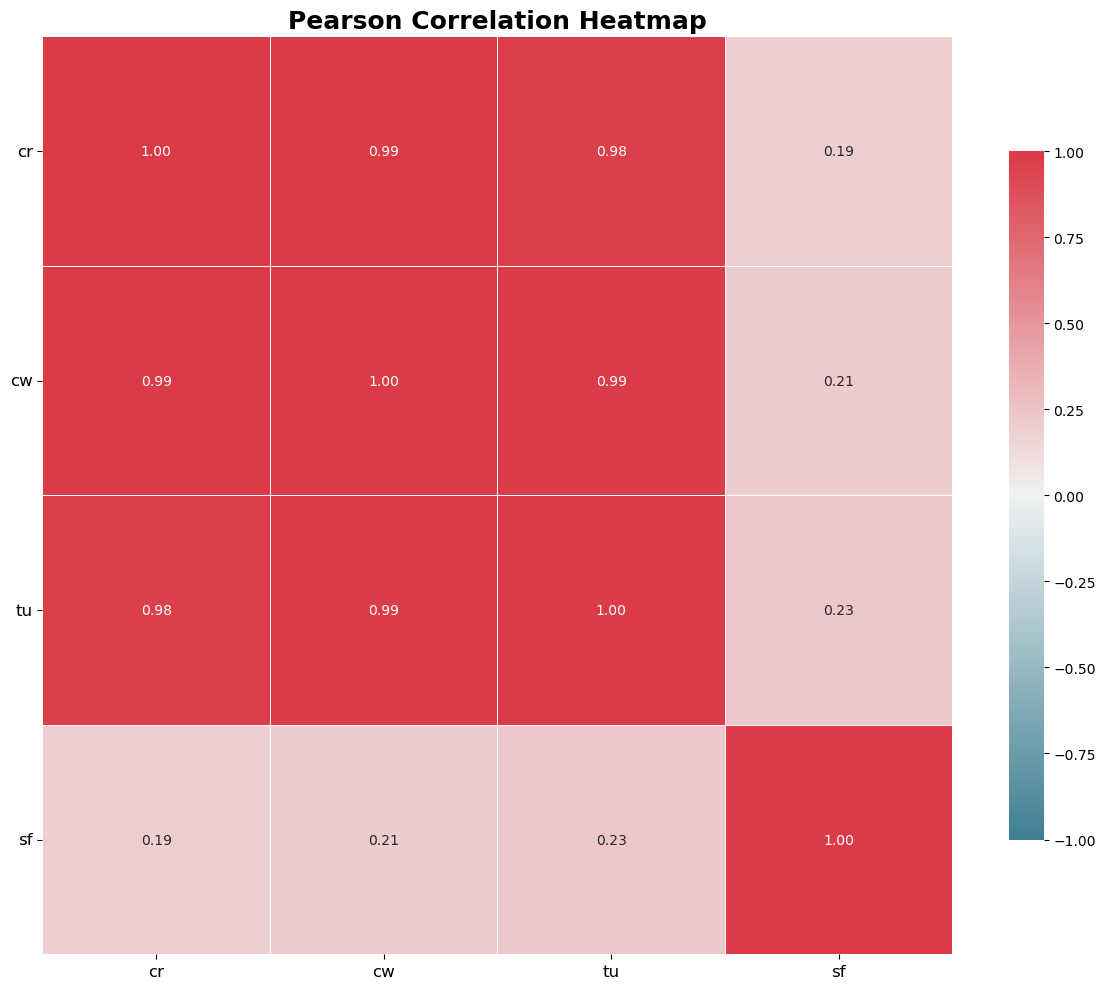

In [62]:
# Compute the correlation matrix
corr_matrix = merged_daily_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Use a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a heatmap with annotations
sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, linewidths=.5, fmt=".2f",
            cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1)

# Improve aesthetics
plt.title('Pearson Correlation Heatmap', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

3.2.2.	Feature Engineering – Temporal Delayed Effect 

Max correlation using CCF for cr is 0.3250824293666728 at lag 4
Max correlation using CCF for cw is 0.33842411548632056 at lag 4
Max correlation using CCF for tu is 0.35818730557028144 at lag 4


C:\Users\Asus\AppData\Local\Temp\ipykernel_15508\1238819403.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(value) for value in ax.get_yticks()], fontsize=12)


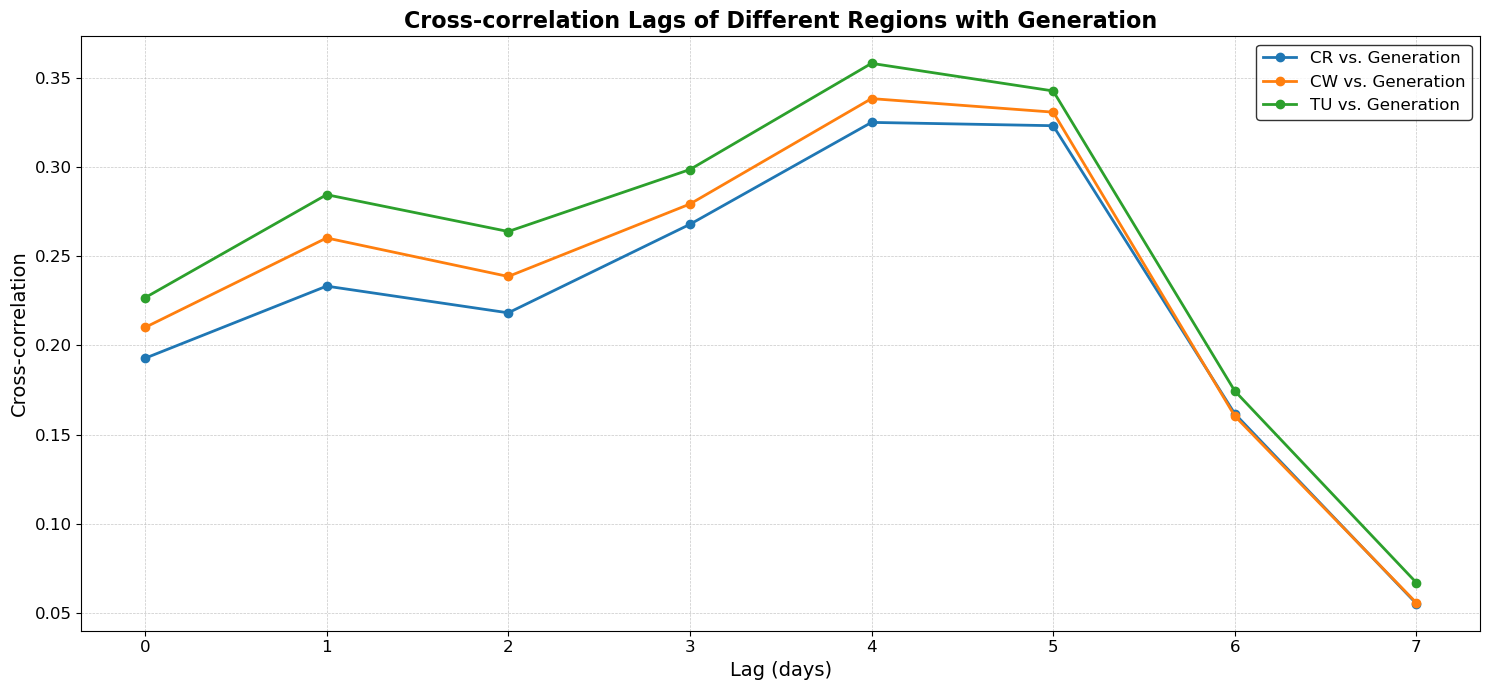

In [64]:
max_lag = 8
regions = ['cr', 'cw', 'tu']

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Colors from the seaborn palette (you can choose others if preferred)
colors = ['tab:blue', 'tab:orange', 'tab:green'] 

for idx, region in enumerate(regions):
    ## Cross-correlation - measuring similarity
    corr_ccf = sm.tsa.stattools.ccf(merged_daily_df[region], merged_daily_df['sf'], adjusted=False)
    # ignore values at lags beyond max_lag
    corr_ccf = corr_ccf[:max_lag]
    max_corr_ccf = max(corr_ccf)
    max_lag_ccf = np.argmax(corr_ccf)
    print('Max correlation using CCF for {} is {} at lag {}'.format(region, max_corr_ccf, max_lag_ccf))

    lags = np.arange(0, len(corr_ccf))
    ax.plot(lags, corr_ccf, label='{} vs. Generation'.format(region.upper()), color=colors[idx], linewidth=2, marker='o')

# Setting axis labels, title, and grid
ax.set_xlabel('Lag (days)', fontsize=14)
ax.set_ylabel('Cross-correlation', fontsize=14)
ax.set_title('Cross-correlation Lags of Different Regions with Generation', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xticks(lags)
ax.set_xticklabels(lags, fontsize=12)
ax.set_yticklabels(['{:.2f}'.format(value) for value in ax.get_yticks()], fontsize=12)

# Display the legend
ax.legend(fontsize=12, loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

Region: cr | Window size: 1
Correlation using Pearson for window size of 1 is 0.1928187906919971
Region: cr | Window size: 2
Correlation using Pearson for window size of 2 is 0.29315420748851356
Region: cr | Window size: 3
Correlation using Pearson for window size of 3 is 0.32453592205552717
Region: cr | Window size: 4
Correlation using Pearson for window size of 4 is 0.33108639511869953
Region: cr | Window size: 5
Correlation using Pearson for window size of 5 is 0.3773353178147057
Region: cr | Window size: 6
Correlation using Pearson for window size of 6 is 0.42433774204762953
Region: cr | Window size: 7
Correlation using Pearson for window size of 7 is 0.45751863905549744
Region: cr | Window size: 8
Correlation using Pearson for window size of 8 is 0.47742837392857895
Region: cr | Window size: 9
Correlation using Pearson for window size of 9 is 0.510287060876018
Region: cr | Window size: 10
Correlation using Pearson for window size of 10 is 0.5350047331248968
Region: cr | Window siz

C:\Users\Asus\AppData\Local\Temp\ipykernel_15508\2743381535.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(value) for value in ax.get_yticks()], fontsize=12)


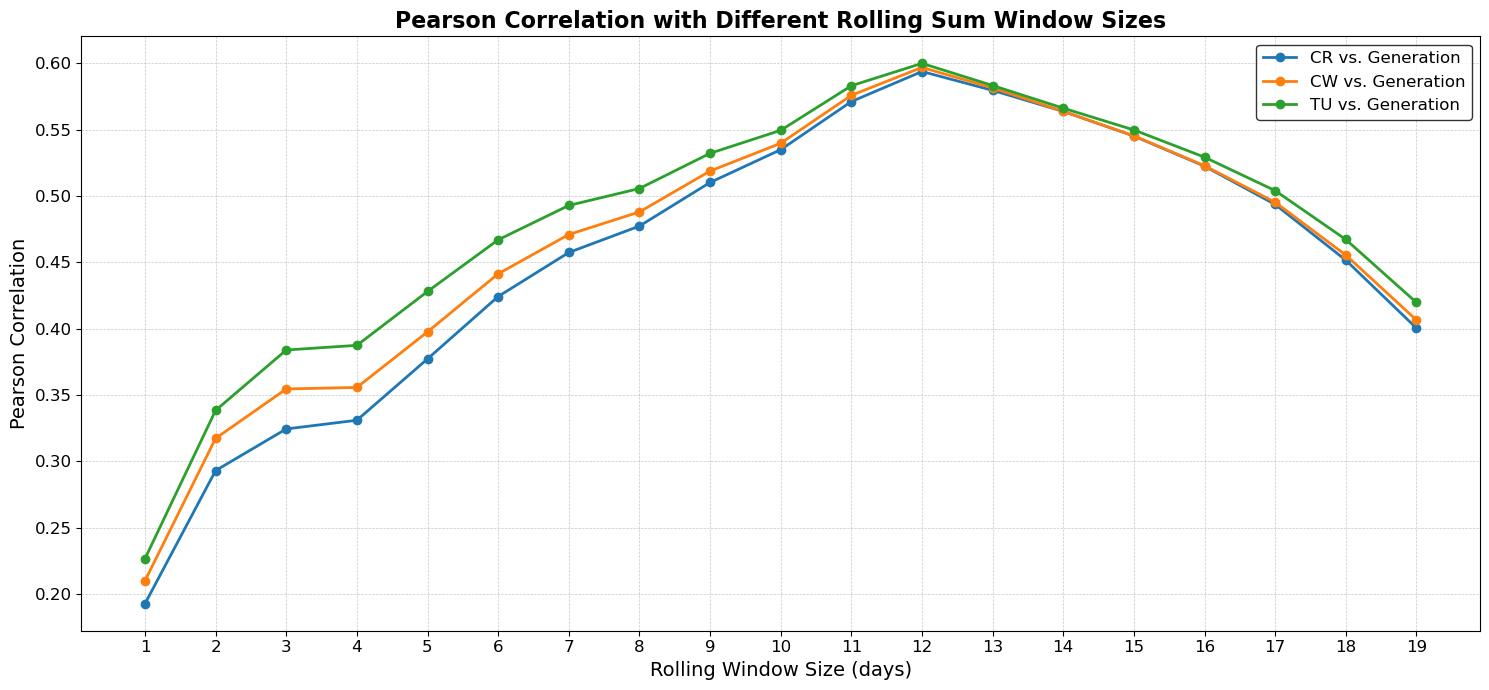

In [68]:
window_sizes = range(1, 20)  # Window sizes from 1 to 19
regions = ['cr', 'cw', 'tu']

# Colors from the seaborn palette (you can choose others if preferred)
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(figsize=(15, 7))

# Loop through each region
for idx, region in enumerate(regions):
    # Store the correlation values for each window size for the current region
    corr_values_p = []

    # Loop through each window size
    for window in window_sizes:
        print("Region:", region, "| Window size:", window)

        # Original dataset copy
        temp_df = merged_daily_df.copy()
        
        # Recalculate rolling sum with current window size for the current region
        column_name = f"{region}_rolling"
        temp_df[column_name] = temp_df[region].rolling(window).sum()

        # Pearson Correlation
        corr_p = temp_df[column_name].corr(temp_df['sf'])
        print('Correlation using Pearson for window size of {} is {}'.format(window, corr_p))
        corr_values_p.append(corr_p)
    
    # Plot the results for the current region
    ax.plot(window_sizes, corr_values_p, label=f'{region.upper()} vs. Generation', color=colors[idx], linewidth=2, marker='o')

# Setting axis labels, title, and grid
ax.set_xlabel('Rolling Window Size (days)', fontsize=14)
ax.set_ylabel('Pearson Correlation', fontsize=14)
ax.set_title('Pearson Correlation with Different Rolling Sum Window Sizes', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xticks(window_sizes)
ax.set_xticklabels(window_sizes, fontsize=12)
ax.set_yticklabels(['{:.2f}'.format(value) for value in ax.get_yticks()], fontsize=12)

# Display the legend
ax.legend(fontsize=12, loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

In [ ]:
# saving the ERA5 Land Reanalysis dataset into a csv file for second part of the model development
#df_ERA5L.to_csv('ERA5_Land.csv')